Each task that is proposed to be completed as part of the homework has a declared "price" in points. The maximum possible amount is 10 points, and together with the bonus assignment - 12 points. It is not necessary to complete all the tasks, only a part can be done. Most of the points expect you to write working Python code; sometimes you will need to write comments - for example, to compare several approaches to solve the same problem. Also you can add more cells for your convenience if you need.

This homework focuses on clustering. We will work with images of handwritten digits, learn how to cluster them using two different methods (hierarchical clustering and the 𝐾-means algorithm), evaluate the quality of the partition and choose the optimal number of clusters, as well as visualize intermediate results.

## 1. Loading data
The data we will be working with is available in the scikit-learn library (`sklearn` module) in the `datasets` submodule via the `load_digits` function. The data contains 1,797 observations, each of which is 8×8 pixel image of a handwritten digit from 0 to 9. This is about the same amount of each digit (about 180).

For convenience, every image expands to a 64 (8×8) row, so entire numpy array is 1797×64. The color intensity in each pixel is encoded with an integer from 0 to 16.

In addition to images, their labels are also known. In this task, we will assume that the labels (as well as their amount) are unknown and try to group the data in such a way that the resulting clusters 'better match' the original ones. Possible options for determining the 'better match' are presented later.

**(0.25 points)** Load the images into `X` variable, and their labels into `y` variable.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

In [2]:
digits = load_digits()
X, y = digits.data, digits.target

In [3]:
assert X.shape == (1797, 64)
assert y.shape == (1797,)

**(0.5 points)** Visualize the first 10 images.

- Arrange images on a grid rather than in a row. You may need the `subplot` and `imshow` functions from the `pyplot` module in the `matplotlib` library.
- You will also need to reshape the images to 8×8.
- Remove ticks and labels from both axes. The `xticks` and `yticks` functions or the `tick_params` function from `pyplot` can help you with this.
- Make the output good sized with the `figure` function from `pyplot`.

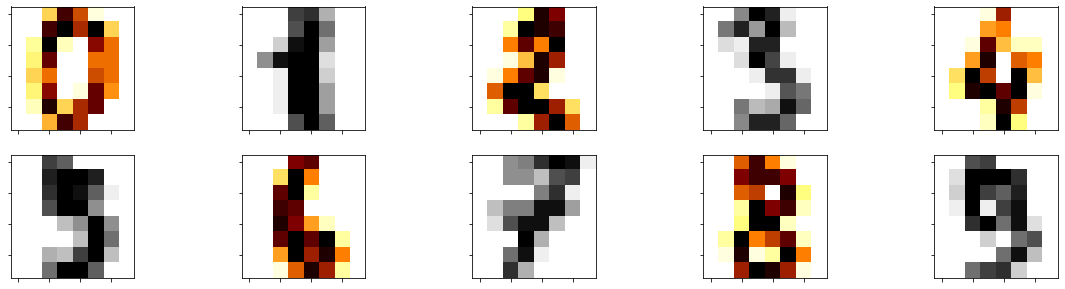

In [4]:
plt.figure(figsize=(20,5))
cycle = 0
for image, label in zip(X[:10], y[:10]):
    cycle += 1
    subplot = plt.subplot(2, 5, cycle)
    plt.xticks(visible=False)
    plt.yticks(visible=False)
    subplot.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)

## 2. Clustering and quality evaluation

**(2 points)** Implement the the KMeans algorithm. Use objective function $L = \sum_{i=1}^{n}|x_{i}-Z_{A(x_{i})}|^{2}$, where $Z_{A(x_{i})}$ is the center of the cluster corresponding to $x_{i}$ object.

In [5]:
# distances = np.zeros((X.shape[0], cluster_centers.shape[0]))
# for i in range(X.shape[0]):
#     distances[i,:] = np.sqrt(np.sum((X[i] - cluster_centers)**2, axis=1))
# return distances

In [6]:
from sklearn.exceptions import NotFittedError
from numpy.random import RandomState
from sklearn.metrics import pairwise_distances

In [7]:
class CustomKMeans:
    def __init__(self, n_clusters=2, max_iter=30, n_init=10, random_state=42):
        '''K-Means clustering.
        
        Args:
            n_clusters: int, default=2
                The number of clusters to be formed is also 
                the number of centroids to generate. 
            max_iter: int, default=300
                Maximum number of iterations of the k-means algorithm for a
                single run.
            n_init: int, default=10
                Number of time the k-means algorithm will be run with different
                centroid seeds. The final results will be the best output of
                n_init consecutive runs in terms of objective function.
            random_state: int, default=42
                Random state.
        '''
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.random_state = RandomState(seed=random_state)
        
    def calculate_distances_to_centroids(self, X, cluster_centers):
        """
        Returns (n, c) matrix where the element at position (i, j) 
        is the distance from i-th object to j-th centroid."""
        distances_to_centroids = pairwise_distances(X, cluster_centers, metric='euclidean')
        return distances_to_centroids
    def update_centroids(self, X, nearest_clusters):
        """
        Returns numpy array of shape (n_clusters, n_features) - 
        new clusters that are found by averaging objects belonging 
        to the corresponding cluster."""
        new_clusters = np.array([np.mean(X[np.where(nearest_clusters == i)], axis=0) for i in np.unique(nearest_clusters)])  
        return new_clusters
        
    def fit(self, X):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        """
        assert X.shape[0] >= self.n_clusters

        self.cluster_centers_ = None
        current_objective = 100000000000
        self.the_objective = 1000000000
        for j in range(self.n_init):
            #for the next task
            row, col = X.shape
            cluster_centers = np.zeros((self.n_clusters, X.shape[1]))
            for i in range(self.n_clusters):
                randIndex = self.random_state.randint(row)
                cluster_centers[i] = X[randIndex]
            for i in range(self.max_iter):
                nearest_clusters = self.calculate_distances_to_centroids(X, cluster_centers)
                cluster_centers = self.update_centroids(X, np.argmin(nearest_clusters, axis=1))
            previous_objective = self.the_objective
            nearest_clusters = self.calculate_distances_to_centroids(X, cluster_centers)
            nearest_clusters_for_l2_norm = np.argmin(self.calculate_distances_to_centroids(X, cluster_centers), axis=1)
            current_objective = np.linalg.norm(X - np.array([cluster_centers[i] for i in nearest_clusters_for_l2_norm]))**2
            if current_objective < previous_objective:
                self.the_objective = current_objective
                self.cluster_centers_ = cluster_centers
        return self
            
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted cluster labels.
        """
        if hasattr(self, 'cluster_centers_'):
            distances_to_predict = self.calculate_distances_to_centroids(X, self.cluster_centers_)
            cluster_labels = np.argmin(distances_to_predict, axis=1)
            return cluster_labels
        else: 
            raise NotFittedError("CustomKMeans instance is not fitted yet")

**(1 points)** Get the `X` array partition into 10 clusters. Visualize the centers of clusters.
- We will assume that the center of the cluster is average value of all observations belonging to the cluster.
- The cluster centers should have the same shape as our observations (64). So you have to average the points across the rows.

In [8]:
custom_kmeans = CustomKMeans(n_clusters=10, max_iter=30, n_init=10, random_state=42)
custom_kmeans.fit(X)
custom_kmeans_labels = custom_kmeans.predict(X)
assert custom_kmeans_labels.shape == (1797,)
print(custom_kmeans_labels)

[0 6 6 ... 6 9 9]


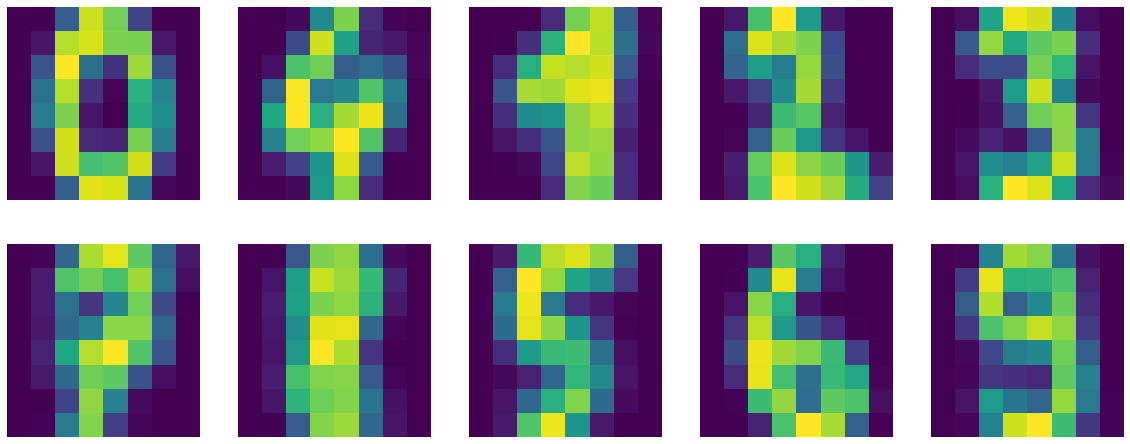

In [9]:
f, ax = plt.subplots(2,5,figsize=(20,8))
count = 0
for i in range(2):
    for j in range(5):
        ax[i, j].imshow(custom_kmeans.cluster_centers_[count].reshape(8,8))
        ax[i, j].set_axis_off()
        count += 1
plt.show()

**(0.5 points)** Experiment with `max_iter` and `n_init` parameters. Look at the range of values of the objective function, it's best values, at what parameters and how often they are achieved.

I took n_inits (5, 10, 25, 100) and max_iters (1, 5, 10, 25, 100) because of my harware but of course we could take more values.

To undeliner, I took final objectives (objective that we get after the model have finished). If you look below at print, or at the graph, you will see that the range of values of objective is between 1165163.289893847 (minimal values) when max_iter is 100 and n_init is 100. (However, the results would differ if I chose another n_inits and max_iters) and upper limit of my range is 1363990.2679796962 (maximum value) when max_iter is 1 and n_init is 5.

As best values I define the ones that are the smallest because in KMeans we try to achieve the smallest possible objective, so the best values in the range is 1165163.289893847 (minimal values) when parameters max_iter is 100 and n_init is 100. The best values I got only once in my range, so it is achieved NOT often.

Moreover, there is a pattern in my results: the more max_iter I have, the smaller objective value I get. And the more n_init I have, the smaller objective values I get. I think it is logical because with new n_init we init random initial centers, so the more times we try to init them, the more variants of final objective we have from which the model can choose the best. The same logic with max_iter: the more times we update centroids, the more chance that we will fit them exactly in the center, the smaller objective we get.

To underline, we would get different results with another n_inits and max_iters arrays.

In [10]:
final_data = []
n_inits = [5,10,25,100]
max_iters = [1,5,10,25,100]
for n_init in n_inits:
    one_n_init = []
    for max_iter in max_iters:
        custom_kmeans = CustomKMeans(n_clusters=10, n_init=n_init, max_iter=max_iter, random_state=15)
        custom_kmeans.fit(X)
        one_n_init.append([custom_kmeans.the_objective])
    final_data.append(one_n_init)
data = pd.DataFrame(final_data)
data.index=n_inits
data.columns=max_iters
print('Rows are n_init, columns are max_iter')
print(data)

Rows are n_init, columns are max_iter
                      1                     5                     10   \
5    [1363990.2679796962]  [1189500.4176312562]  [1172324.5524336046]   
10   [1292548.4368254226]  [1176009.1982466748]  [1168628.8186439113]   
25   [1278762.2939430596]  [1176009.1982466748]   [1165916.729275183]   
100  [1278762.2939430596]  [1173588.1454447745]   [1165916.729275183]   

                      25                    100  
5     [1167899.048219508]   [1167899.048219508]  
10   [1167778.8966008844]  [1167778.8966008844]  
25   [1165282.7745391673]  [1165282.7745391673]  
100  [1165187.6332150497]   [1165163.289893847]  


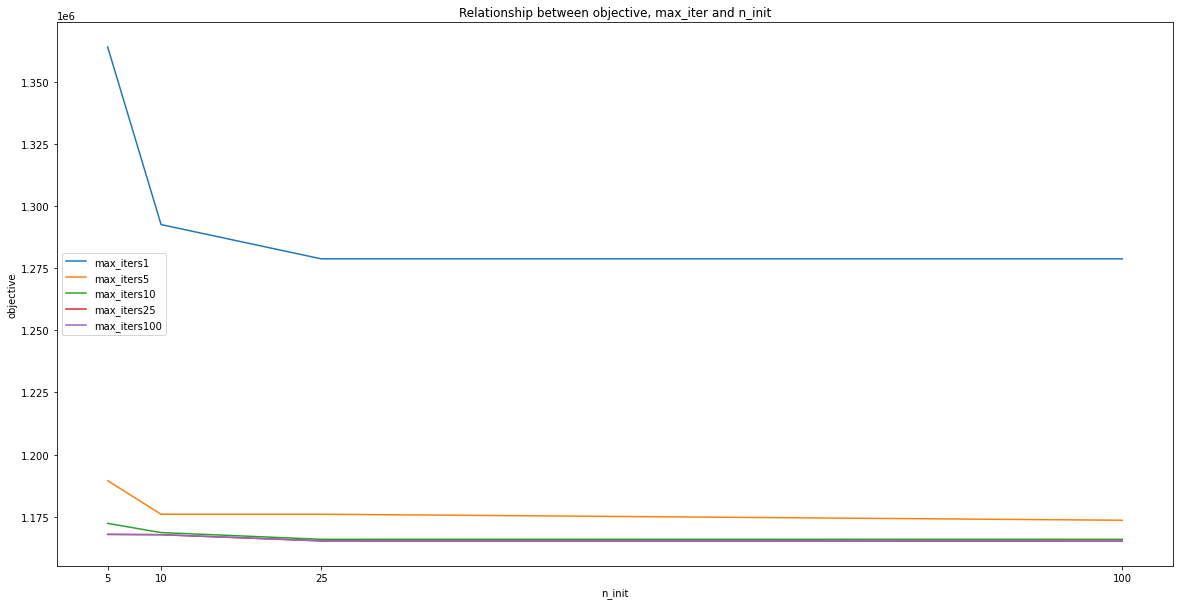

In [11]:
plt.figure(figsize=(20, 10))
data_for_the_graph = np.array(final_data).T
for i in range(len(max_iters)):
    label = "max_iters" + str(max_iters[i])
    data = data_for_the_graph[0][i]
    plt.plot(n_inits, data, label=label)
plt.title('Relationship between objective, max_iter and n_init')
plt.xticks(n_inits)
plt.xlabel('n_init')
plt.ylabel('objective')
plt.legend(loc='center left')
plt.show()

Now we will use two popular algorithms: hierarchical clustering and $K$-means clustering. These and other algorithms are available in the `scikit-learn` module in the `cluster` submodule. Hierarchical clustering is called `AgglomerativeClustering`, and the $K$-means method is called `KMeans`.

**(0.5 points)** Use each of the two methods: hierarchical clustering and KMeans. Get the `X` array partition into 10 clusters.

- Note that `AgglomerativeClustering` does not have a `predict` method, so you can either use the `fit_predict` method or use the `fit` method and then look at the `labels_` attribute of the class instance.
- Kmeans performs multiple runs (default 10) with random centers and then returns the best partition in terms of average distance within the clusters. You can increase the number of runs to improve the quality of predictions in the `i_init` parameter.

In [12]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
hierarchical_clustering = AgglomerativeClustering(n_clusters=10).fit(X)
hierarchical_labels = hierarchical_clustering.labels_ 
kmeans = KMeans(n_clusters=10, random_state=42).fit(X)
kmeans_labels = kmeans.labels_

In [13]:
assert hierarchical_labels.shape == (1797,)
assert kmeans_labels.shape == (1797,)

**(0.5 points)** Visualize the centers of clusters obtained by both methods.

**_Hierarchical Clusteing (Agglomerative Clustering)_**

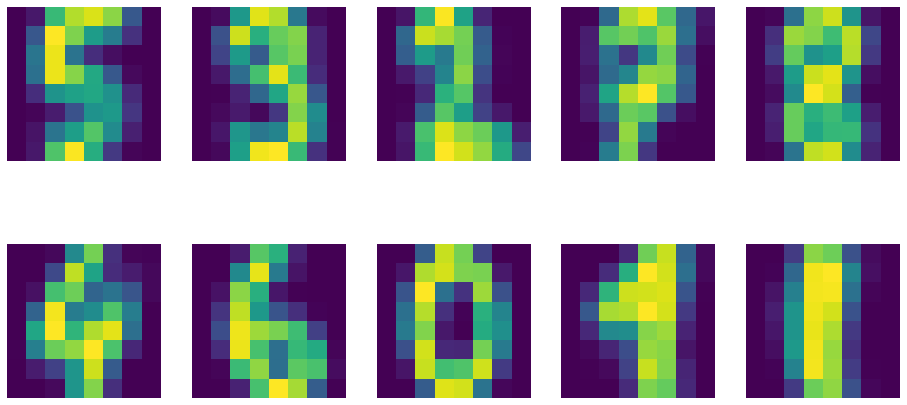

In [14]:
center=[]
for i in set(hierarchical_labels):
    x = np.mean(X[np.where(hierarchical_labels == i)], axis=0)
    center.append(list(x))
hierarchical_clustering_centers = np.array(center)
f, ax = plt.subplots(2,5,figsize=(16,8))
count = 0
for i in range(2):
    for j in range(5):
        ax[i, j].imshow(hierarchical_clustering_centers[count].reshape(8,8))
        ax[i, j].set_axis_off()
        count += 1
plt.show()

**_KMeans clustering_**

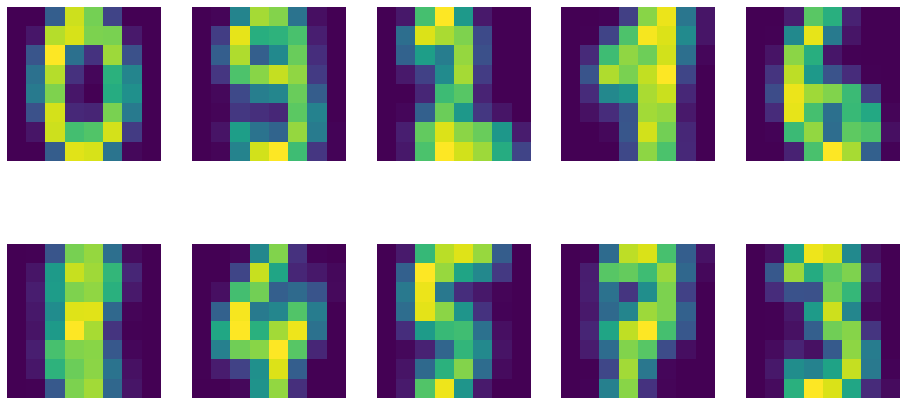

In [15]:
f, ax = plt.subplots(2,5,figsize=(16,8))
count = 0
for i in range(2):
    for j in range(5):
        ax[i, j].imshow(kmeans.cluster_centers_[count].reshape(8,8))
        ax[i, j].set_axis_off()
        count += 1
plt.show()

In a situation where the true number of classes is unknown, we can select it by maximazing some metric.

When we can set some distance function between our observations, we can consider the `silhouette` distance as a function of measuring the quality of the clustering. Let's show how it is calculated:

Let $X$ – set of observations, $M \subset X$ – one of the clusters obtained as a result of clustering process, $\rho$ – some metric on $X$. Let's choose one observation $x \in M$. Denote $a(x)$ as the average distance from $x$ to  $x'$ points from the same cluster:
$$
a(x) = \frac{1}{|M| - 1} \sum_{x' \in M,\, x' \ne x} \rho(x,\, x')
$$

Denote $b(x)$ as minimun of average distances from $x$ to $x''$ from some other cluster $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

The silhouette is difference between a(x) and b(x), normalized to $[-1, \, 1]$ and averaged over all observations:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

The implementation of this metric in the `scikit-learn` is the `silhouette_score` function from the `metrics` submidule.

**(0.75 point)** For each $K$ between 2 and 20 inclusive, partition of the array $X$ into $K$ clusters using both methods. Calculate the silhouette score and visualize it for both methods on the same plot ($K$ on the $x$ axis and silhouette score on the $y$ axis). Sign the axes and make a legend.

**_Calculater the silhouette score_**

In [16]:
from sklearn.metrics import silhouette_score
silhoutte_score_kmeans = []
silhoutte_score_agglomerative_clustering = []
number_of_clusters = range(2, 21)
for n_clusters in number_of_clusters:
    hierarchical_clustering = AgglomerativeClustering(n_clusters=n_clusters).fit(X)
    hierarchical_labels = hierarchical_clustering.labels_
    silhoutte_score_agglomerative_clustering.append(silhouette_score(X, hierarchical_labels))
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    kmeans_labels = kmeans.labels_
    silhoutte_score_kmeans.append(silhouette_score(X, kmeans_labels))

**_Plot silhoutter score_**

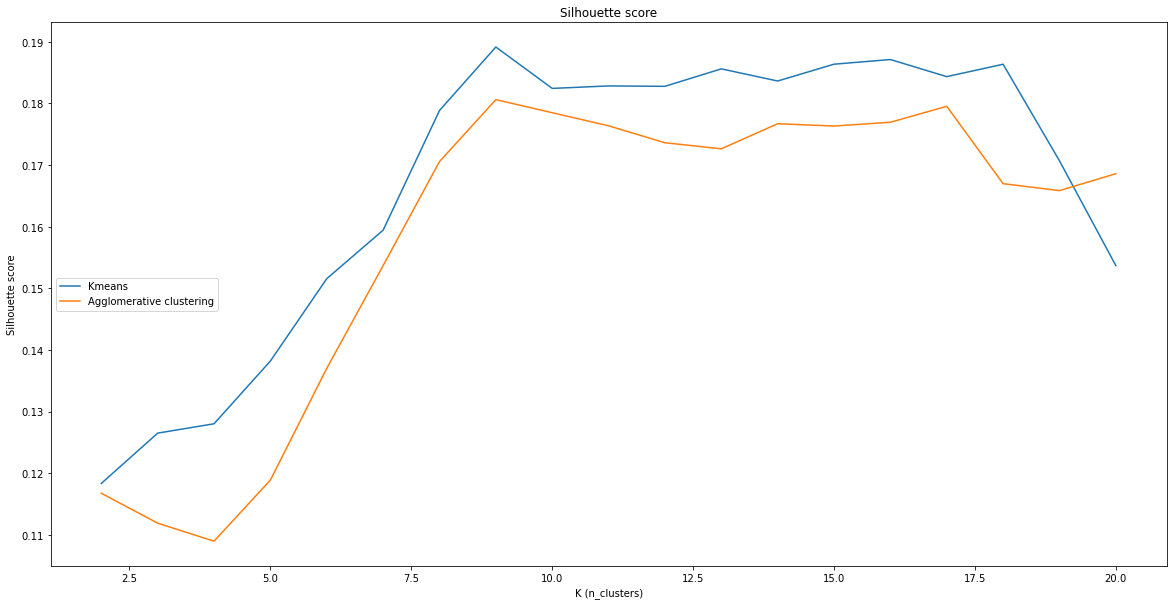

In [17]:
plt.figure(figsize=(20, 10))
x_axis = number_of_clusters
plt.plot(x_axis, silhoutte_score_kmeans, label='Kmeans')
plt.plot(x_axis, silhoutte_score_agglomerative_clustering, color='C1', label='Agglomerative clustering')
plt.title('Silhouette score')
plt.xlabel('K (n_clusters)')
plt.ylabel('Silhouette score')
plt.legend(loc='center left')               
plt.show()

When we know the true clustering labels, the clustering result can be compared to them using measures such as `homogeneity`, `completeness` and their harmonic mean - $V$-score. The definitions of these quantities are rather bulky and are based on the [entropy of the probability distribution](https://ru.wikipedia.org/wiki/Информационная_энтропия). Details are given in [this article](http://aclweb.org/anthology/D/D07/D07-1043.pdf). In practice, it's enough to know that `homogeneity`, `completeness` and $V$-score are in the range from 0 and 1, and the more, the better.

Since we know what digit each image is (`y` array), we can compare the clustering results to it using the measures listed above.

**(0.5 points)** Repeat the previous task using $V$-measure instead of silhouette.

**_Calculate V measure score_**

In [18]:
from sklearn.metrics import v_measure_score
v_measure_score_kmeans = []
v_measure_score_agglomerative_clustering = []
number_of_clusters = range(2, 21)
for n_clusters in number_of_clusters:
    #hierarhical clustering
    hierarchical_clustering = AgglomerativeClustering(n_clusters=n_clusters).fit(X)
    hierarchical_labels = hierarchical_clustering.labels_
    v_measure_score_agglomerative_clustering.append(v_measure_score(y, hierarchical_labels))
    
    #kmeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    kmeans_labels = kmeans.labels_
    v_measure_score_kmeans.append(v_measure_score(y, kmeans_labels))

**_Plot V score_**

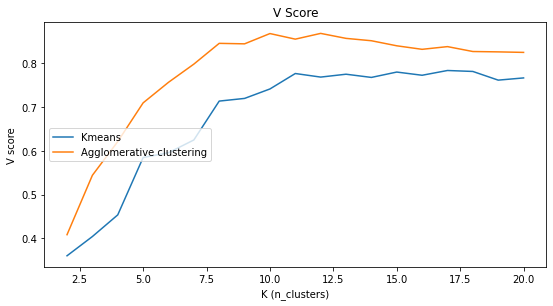

In [19]:
plt.figure(figsize=(9, 4.5))
x_axis = number_of_clusters
plt.plot(x_axis, v_measure_score_kmeans, label='Kmeans')
plt.plot(x_axis, v_measure_score_agglomerative_clustering, color='C1', label='Agglomerative clustering')
plt.title('V Score')
plt.xlabel('K (n_clusters)')
plt.ylabel('V score')
plt.legend(loc='center left')               
plt.show()

## 3. Feature space dimensionality reduction

In some cases, especially when there are a large number of features, when not all of them are informative, and some of them are correlated, it can be useful to reduce the dimension of the feature space. This mean that instead of $d$ original features, we will go to $d'\ll d$ new ones. And if earlier our data were presented in the form of an $n×d$ matrix, then it will presented as a $n×d'$.

There are two popular dimensionality reduction approaches:
- select new features from existing features;
- extract the new features by transforming old ones, for example, by making $d'$ different linear combinations of columns of an $n×d$ matrix.

One widely used dimensionality reduction technique is the Singular Value Decomposition (SVD). This method allows you to construct any number $d'\leq d$ of new features in such a way that they are the most informative (in some sense).

The `scikit-learn` module has several implementations of singular value decomposition. We will use the `TruncatedSVD` class from the `decomposition` submodule.

**Note:** The singular value decomposition of the matrix $M$ is usually written as $M=U \Sigma V^{*}$. `TruncatedSVD`, in turn, returns only the $d'$ first columns of the matrix $U$.

**(0.75 point)** Perform a singular value decomposition of the $X$ matrix, leaving 2, 5, 10, 20 features. In each case, perform hierarchical clustering and $K$-Means clustering (take the number of clusters equal to 10). Calculate the silhouette and $V$-score and compare them to corresponding values obtained from the original data.

**Note**: It is not valid to compare the silhouette calculated with different metrics. Even if we use the same metric function when calculating the distance between points in the data, after applying dimensionality reduction or other data transformations, we will (not always) get different silhouette scores. Therefore, after training the clustering algorithm, to compare the result of clustering, you need to calculate the silhouette on the original data.

**_I didn't center the data as it is not neccessary for TruncatedSVD. As I researched: TruncatedSVD is useful on large sparse datasets which cannot be centered without making the memory usage explode._**

**_silhouette score of hierarchical clustering and  𝐾 -Means clustering (take the number of clusters equal to 10) after TruncatedSVD_**

In [20]:
from sklearn.decomposition import TruncatedSVD
number_of_components = [2, 5, 10, 20]

In [21]:
number_of_components = [2, 5, 10, 20]
silhouette_score_agglomerative_clustering = []
silhouette_score_kmeans = []
for the_number in number_of_components:
    truncatedSVD = TruncatedSVD(n_components=the_number)
    data_with_needed_amount_of_features = truncatedSVD.fit_transform(X)
    
    hierarchical_clustering = AgglomerativeClustering(n_clusters=10).fit(data_with_needed_amount_of_features)
    hierarchical_labels = hierarchical_clustering.labels_
    silhouette_score_agglomerative_clustering.append(silhouette_score(X, hierarchical_labels))

    kmeans = KMeans(n_clusters=10, random_state=42).fit(data_with_needed_amount_of_features)
    kmeans_labels = kmeans.labels_
    silhouette_score_kmeans.append(silhouette_score(X, kmeans_labels))
print('Kmeans silhouette score: ', silhouette_score_kmeans)
print('Hierarhical clustering silhouette score: ', silhouette_score_agglomerative_clustering)

Kmeans silhouette score:  [0.006294643408975287, 0.16859796560589405, 0.1804636360123699, 0.1821489801808095]
Hierarhical clustering silhouette score:  [-0.007681018630218928, 0.1620113963829507, 0.1765881132796084, 0.16913283397404957]


**_Original data silhouette score_**

In [22]:
hierarchical_clustering = AgglomerativeClustering(n_clusters=10).fit(X)
hierarchical_labels = hierarchical_clustering.labels_
silhouette_score_agglomerative_clustering_all_features = (silhouette_score(X, hierarchical_labels))

#kmeans
kmeans = KMeans(n_clusters=10, random_state=42).fit(X)
kmeans_labels = kmeans.labels_
silhouette_score_kmeans_all_features = (silhouette_score(X, kmeans_labels))
print('Kmeans silhouette score: ', silhouette_score_kmeans_all_features)
print('Hierarhical clustering silhouette score: ', silhouette_score_agglomerative_clustering_all_features)

Kmeans silhouette score:  0.18244258012780126
Hierarhical clustering silhouette score:  0.17849659940596496


From scikit-learn documentation: The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

Consequently, I see that silhouette scores for original data both with Kmeans and Hierarhical clustering (0.18244258012780126, 0.17849659940596496) are better than silhoutter scores of data after TruncatedSVD (you can see those scores above). Moreover, after TruncatedSVD with more features left the silhoutter score for Kmeans is bigger: for example, score for 20 features left (0.1821489801808095) is bigger than for 10 features left (0.1804636360123699). As for the hierarhical clustering, in general the silhouette score is bigger with more features left after TruncatedSVD but in case of 20 feature left the score 0.16913283397404957 is slightly smaller than with 10 features 0.1765881132796084.

**_V score hierarchical clustering and  𝐾 -Means clustering (take the number of clusters equal to 10) after TruncatedSVD_**

In [23]:
number_of_components = [2, 5, 10, 20]
v_measure_score_agglomerative_clustering = []
v_measure_score_kmeans = []
for the_number in number_of_components:
    truncatedSVD = TruncatedSVD(n_components=the_number)
    data_with_needed_amount_of_features = truncatedSVD.fit_transform(X)

    hierarchical_clustering = AgglomerativeClustering(n_clusters=10).fit(data_with_needed_amount_of_features)
    hierarchical_labels = hierarchical_clustering.labels_
    v_measure_score_agglomerative_clustering.append(v_measure_score(y, hierarchical_labels))
    
    kmeans = KMeans(n_clusters=10, random_state=42).fit(data_with_needed_amount_of_features)
    kmeans_labels = kmeans.labels_
    v_measure_score_kmeans.append(v_measure_score(y, kmeans_labels))
print('Kmeans V score: ', v_measure_score_kmeans)
print('Hierarhical clustering V Score: ', v_measure_score_agglomerative_clustering)

Kmeans V score:  [0.34658416124331604, 0.6351431850310998, 0.721568958475907, 0.7403084189251903]
Hierarhical clustering V Score:  [0.3337189903948925, 0.6756036446423491, 0.8259753348813222, 0.8143882689038883]


**_Original data V score_**

In [24]:
hierarchical_clustering = AgglomerativeClustering(n_clusters=10).fit(X)
hierarchical_labels = hierarchical_clustering.labels_
v_measure_score_agglomerative_clustering_all_features = (v_measure_score(y, hierarchical_labels))

kmeans = KMeans(n_clusters=10, random_state=42).fit(X)
kmeans_labels = kmeans.labels_
v_measure_score_kmeans_all_features = (v_measure_score(y, kmeans_labels))
print('Kmeans: ', v_measure_score_kmeans_all_features)
print('Hierarhical clustering: ', v_measure_score_agglomerative_clustering_all_features)

Kmeans:  0.7414681265635256
Hierarhical clustering:  0.8681701126909083


From scikit learn documentation: score between 0.0 and 1.0. 1.0 stands for perfectly complete labeling.

Similar to the case with silhouette score, original data's V scores with Kmeans and Hierarhical clustering (0.7414681265635256, 0.8681701126909083) are better than the scores after TruncatedSVD. Moreover, we have the same pattern as with silhouette score, the more features we have left after using TruncatedSVD, the better the score we have (and this difference is score is significant between 2 and 5 features). For example, with Kmeans with 20 features we have a V score  0.7403084189251903 and with 10 features we have 0.721568958475907. However, with Hierarhical clustering in general we have a better score with more features BUT score with 20 features 0.8143882689038883 is slightly smaller than with 0.8259753348813222 features.

Another popular dimensionality reduction approach that is useful for working with images is t-distributed stochastic neighbor embeddings, abbreviated `tSNE`. Unlike singular value decomposition, this it is non-linear transformation. It's main idea is to map points from a space of dimension `d` to another space of dimension 2 or 3 in such a way that the distances between points are mostly preserved. Mathematical details can be found, for example, [here](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding).

The implementation of `tSNE` in the `scikit-learn` library is the `TSNE` class in the `manifold` submodule.

**Note:** In recent years [UMAP](https://github.com/lmcinnes/umap) is often used istead of `tSNE`. It is a faster algorithm with similar properties. We don't ask you to use `UMAP` because it requires you to install another dependency, the `umap-learn` library. Those who wish can perform the following task using `UMAP`.

**(0.5 points)** Perform a tSNE-transform of the `X` matrix, leaving 2 features. Visualize the obtained data in the form of a scatter plot form: the first feature on the horizontal axis, and the second one the vertical axis. Color the points according to the digits they belong to.

- The `c` parameter in the plt.scatter function is responsible for the color of the points. Pass the true labels to it.

**_Perform a tSNE-transform of the X matrix, leaving 2 features_**

In [25]:
from sklearn.manifold import TSNE
X, y = digits.data, digits.target
X_tsne = TSNE(n_components=2, random_state=15).fit_transform(X)

D:\MiniConda\envs\rsschool-machine-learning-course\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\MiniConda\envs\rsschool-machine-learning-course\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


**_Visualize the obtained data in the form of a scatter plot form_**

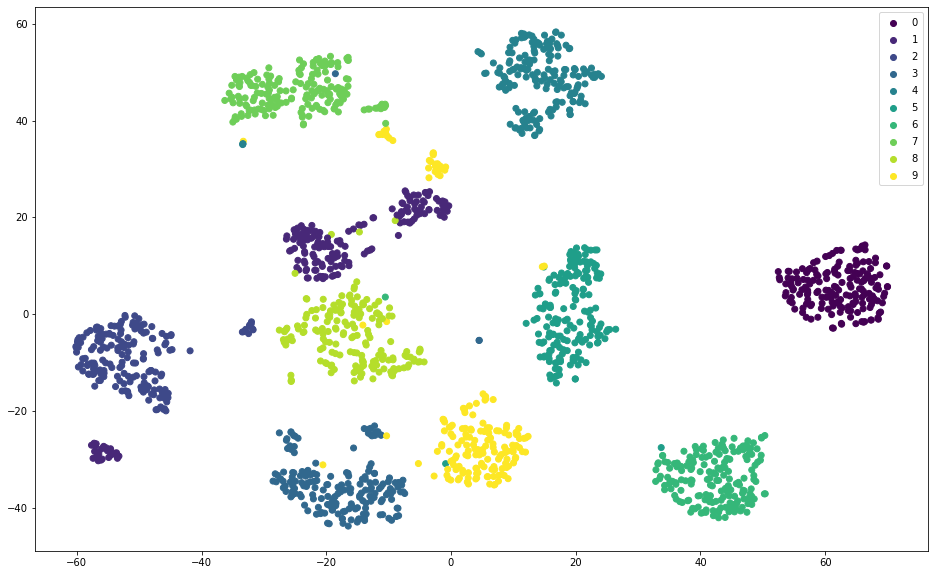

In [26]:
X_axis = X_tsne[:,0]
Y_axis = X_tsne[:,1]
plt.figure(figsize=(16,10))
graph = plt.scatter(x=X_axis, y=Y_axis, c=y);
plt.legend(*graph.legend_elements())

**(0.5 points)** From the data transformed using the tSNE, perform hierarchical clustering and $K$-means clustering (take the number of clusters equal to 10). Calculate the silhouette and the $V$-score and compare them to corresponding values obtained from the original data.

**_Silhoutte score of data transformed using tSNE_**

In [27]:
silhouette_score_agglomerative_clustering = None
silhouette_score_kmeans = None

hierarchical_clustering = AgglomerativeClustering(n_clusters=10).fit(X_tsne)
hierarchical_labels = hierarchical_clustering.labels_
silhouette_score_agglomerative_clustering = silhouette_score(X_tsne, hierarchical_labels)

kmeans = KMeans(n_clusters=10, random_state=42).fit(X_tsne)
kmeans_labels = kmeans.labels_
silhouette_score_kmeans = silhouette_score(X_tsne, kmeans_labels)
print('Kmeans after tSNE: ', silhouette_score_kmeans)
print('Hierarhical clustering after tSNE: ', silhouette_score_agglomerative_clustering)

Kmeans after tSNE:  0.6514431
Hierarhical clustering after tSNE:  0.6518042


**_Silhoutte score of original data_**

In [28]:
hierarchical_clustering = AgglomerativeClustering(n_clusters=10).fit(X)
hierarchical_labels = hierarchical_clustering.labels_
silhouette_score_agglomerative_clustering_all_features = (silhouette_score(X, hierarchical_labels))

#kmeans
kmeans = KMeans(n_clusters=10, random_state=42).fit(X)
kmeans_labels = kmeans.labels_
silhouette_score_kmeans_all_features = (silhouette_score(X, kmeans_labels))
print('Kmeans: ', silhouette_score_kmeans_all_features)
print('Hierarhical clustering: ', silhouette_score_agglomerative_clustering_all_features)

Kmeans:  0.18244258012780126
Hierarhical clustering:  0.17849659940596496


As we can see Silhoeutte score (kmeans 0.6514431, hierarhical clustering 0.6518042) after using tSNE is significantly bigger than silhoette score of original data (Kmeans 0.18244258012780126, hierarhical clustering 0.17849659940596496).

**_V score of data transformed using tSNE_**

In [29]:
v_measure_score_agglomerative_clustering = None
v_measure_score_kmeans = None

hierarchical_clustering = AgglomerativeClustering(n_clusters=10).fit(X_tsne)
hierarchical_labels = hierarchical_clustering.labels_
v_measure_score_agglomerative_clustering = v_measure_score(y, hierarchical_labels)

kmeans = KMeans(n_clusters=10, random_state=42).fit(X_tsne)
kmeans_labels = kmeans.labels_
v_measure_score_kmeans = v_measure_score(y, kmeans_labels)
print('Kmeans after tSNE: ', v_measure_score_kmeans)
print('Hierarhical clustering after tSNE: ', v_measure_score_agglomerative_clustering)

Kmeans after tSNE:  0.9176139542437043
Hierarhical clustering after tSNE:  0.9221280257414504


**_V score of original data_**

In [30]:
hierarchical_clustering = AgglomerativeClustering(n_clusters=10).fit(X)
hierarchical_labels = hierarchical_clustering.labels_
v_measure_score_agglomerative_clustering_all_features = (v_measure_score(y, hierarchical_labels))

kmeans = KMeans(n_clusters=10, random_state=42).fit(X)
kmeans_labels = kmeans.labels_
v_measure_score_kmeans_all_features = (v_measure_score(y, kmeans_labels))
print('Kmeans: ', v_measure_score_kmeans_all_features)
print('Hierarhical clustering: ', v_measure_score_agglomerative_clustering_all_features)

Kmeans:  0.7414681265635256
Hierarhical clustering:  0.8681701126909083


As we can see V score (kmeans 0.9176139542437043, hierarhical clustering 0.9221280257414504) after using tSNE is significantly bigger than V score of original data (Kmeans 0.7414681265635256, hierarhical clustering 0.8681701126909083).

tSNE tries to find the underlying structure of the data by considering the neighbors of a sample. By prioritizing the neighbor points gives an advantage when data structure is a manifold. May be that's because tSNE improved the results significantly in comaprison to TruncateSVD.

**(0.25 points)** Choose the best partition (in terms of silhouette or $V$-score) and visualize the centers of clusters with images. Did you managed to make each digit correspond to one center of the cluster?

**_Choose the best partitioner_**

Both in terms of silhouette and V scores, the tSNE algorithms with Hierarhical clustering was the best partitioner. TruncateSVD decreased the scores and original data scores were not as high as scores of tSNE. To underline, the scores of Kmeans and Hierarchical clustering are almost the same, so we could choose Kmeand as well.

**_Visualize the centers of clusters with images_**

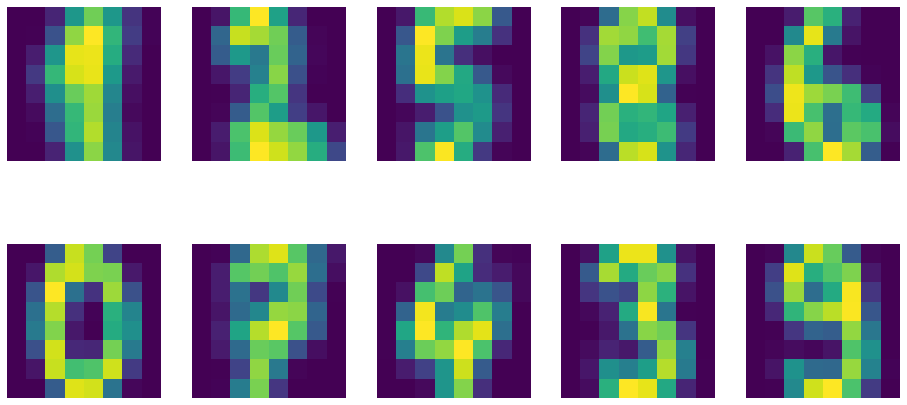

In [31]:
hierarchical_clustering = AgglomerativeClustering(n_clusters=10).fit(X_tsne)
hierarchical_labels = hierarchical_clustering.labels_
center=[]
for i in set(hierarchical_labels):
    x = np.mean(X[np.where(hierarchical_labels == i)], axis=0)
    center.append(list(x))
hierarchical_clustering_centers = np.array(center)
f, ax = plt.subplots(2,5,figsize=(16,8))
count = 0
for i in range(2):
    for j in range(5):
        ax[i, j].imshow(hierarchical_clustering_centers[count].reshape(8,8))
        ax[i, j].set_axis_off()
        count += 1
plt.show()

**_Did you managed to make each digit correspond to one center of the cluster?_**

As seen above, each cluster corresponds to one digit (and it is almost impossible not to determine the number from the image), so I think yes, I managed to make each digit correspond to one center of the cluster.

Moreover, if you scroll up to original image of centers of hierarhical clustering that I had in task #2, you will see that after tSNE cluster centers look more clear than there.

## 4. Results and bonus part

Write in free form what conclusions you made after completing this assignment. Answer the following questions:

**(0.5 points)** Which algorithm gives more meaningful results - hierarchical clustering or $K$- means clustering. Does it depend on the algorithm settings or on the quality evaluation method?

In general, both K-means and hierarchical clustering gave similar results.

If we take a deeper look depending on algorithm settings and metrics:
 - after tSNE hierarchical clustering showed slightly better results than Kmeans with V score and silhouette
 - on original data with V score hierarhical clustering showed better results
 - on original data with silhoutte Kmeans showed better results
 - after TruncatedSVD V score of Hierarchical clustering is better (besides the case when number of components is 2.
 - after TruncatedSVD silhoutte score of Kmeans is slightly better
 
 So yes, I think it depends on the algorithm setting (how we changed the data before giving it to models) and evaluation method (parameters of Kmeans and hierarchical clustering I tried to state the same). If I need to choose only one model, I would say that hierarchical clustering gave more meaningful results because if we look above it showed better results more often than Kmeans (even though Kmeans is not far away from it and sometimes even suprasses hierarchical clustering)

**(0.5 points)** Imagine the situation where after hierarchical clustering, you need to cluster new data in the same way without retraining the model. Suggest a method how you will do it and how you will measure the quality of clustering of new data.

AgglomerativeClustering which we used in the homework as hierarhical clustering doesn't have a method predict so we cannot cluster new data without retraining the model.

Clustering is not supposed to classify new data. If I do not want to retrain the model and I need to cluster new data in the same way, I would suggest create another classifier (for example, KNN) on top of the labeled data given by hierarhical clustering. We can measure the quality using V score (with their real labels) or silhoeutte metrics and compare the results.

**(0.5 points)** Does dimensionality reduction improve clustering results?

Dimensionality reduction in the form of TruncatedSVD decreased silhoutter and V scores
of the KMeans and hierarhical clustering. (In general, the less features we had left, the less scores were). May be that's because some useful features were actually omitted.
It doesn't mean that in general dimensionality reduction TruncatedSVD decreases the score. Just with
this dataset it is as it is.


Dimensionality reduction in the form of tSNE increased silhouetter and V scores of the 
KMeans and hierarchical clustering. tSNE tries to find the underlying structure of the data by considering the neighbors of a sample. By prioritizing the neighbor points gives an advantage when data structure is a manifold. 
May be that's because tSNE improved the results significantly in comaprison to TruncateSVD. Or may be there is another reason.

So yes, dimensionality reduction improves the clustering results just not all types of dimensionality reduction and not with all datasets.

**(0.5 points)** How to evaluate the quality of dimensional reduction? Suggest at least 2 options.

The main purpose of applying dimensionality reduction on data is to capture the original data's distribution as much as possible even after the dimensionality reduction.

How to evaluate the quality of dimensional reduction:

1. We use dimensional reduction to prepare data for the model. So basically we can use different dimensional reductions methods and evaluate models trained on them and on original data using metrics (for clustering, silhouetter and V scores, for linear regression R2 and etc.) After comparision, we will see which dimensional reduction led to better results on a model.

2. There is a rank-based criteria for measuring quality of dimensional reduction. There is the whole paper about it: https://sites.uclouvain.be/DRedVis/NeuCom_art_2009_JL.pdf

3. The reconstruction of the data (from Hands-on book https://www.amazon.de/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1491962291/ref=sr_1_fkmr0_1?ie=UTF8&qid=1546518076&sr=8-1-fkmr0&keywords=hands%20on%20machine%20learning%20and%20scikit%20-learn)

    We use:
    X_reduced = pca.fit_transform(X_train)
    
    X_recovered = pca.inverse_transform(X_reduced)

    And calculate the mean squared distance between the original data and the reconstructed data. In this case the error shows what technique reduces dimensions more accurately and/or makes it possible to recover the original data set.

**(Bonus 2 points)** Load the [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist) dataset. You can also do it with `scikit-learn` as explained [here](https://stackoverflow.com/a/60450028). Explore the data and try to cluster it using different approaches. Compare results of these approaches using the silhouette and the $V$-score.

**_Load the MNIST Handwritten Digits_**

In [78]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

**_Explore the data_**

Let's look at X and y

In [79]:
X

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
y

0        5
1        0
2        4
3        1
4        9
        ..
69995    2
69996    3
69997    4
69998    5
69999    6
Name: class, Length: 70000, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

Now let's look at the shapes

In [81]:
X.shape, y.shape

((70000, 784), (70000,))

As I googled it is the right shape

In [82]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Columns: 784 entries, pixel1 to pixel784
dtypes: float64(784)
memory usage: 418.7 MB


In [83]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 70000 entries, 0 to 69999
Series name: class
Non-Null Count  Dtype   
--------------  -----   
70000 non-null  category
dtypes: category(1)
memory usage: 68.9 KB


We don't have missing data

Let's plot our data

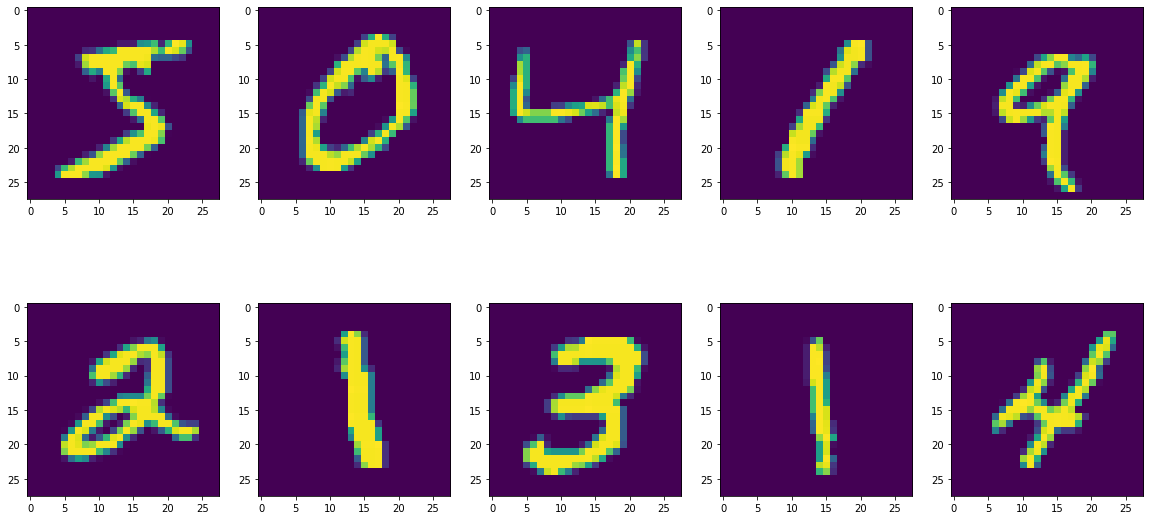

In [84]:
plt.figure(figsize=(20, 10))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X.values.reshape(-1, 28, 28)[i])

We see clear images of digits.

Of course, we could explore further our data but for the study purpose focusing on clustering (without emphasizing accuracy), I don't think that I need to go any deeper

**_Try to cluster it using different approaches_**

Spoiler: as it turned out, dataset is too big and when I use hierarchical clustering, my computer computes the results for hours,
so I decreased the dataset, so I can use both Kmeans and hierarchical clustering.

In [85]:
from sklearn.model_selection import train_test_split
X_data, X_test, y_data, y_test = train_test_split(X, y, test_size=0.80, random_state=42)

In [86]:
X_data.shape, y_data.shape

((14000, 784), (14000,))

I will use only 20% of the data (in other words, I will use X_train, y_train.

**_Kmeans with original data_**

In [87]:
kmeans = KMeans(n_clusters=10, random_state=42).fit(X_data)
kmeans_labels = kmeans.labels_
v_measure_score_kmeans_all_features = (v_measure_score(y_data, kmeans_labels))
print('Kmeans V score: ', v_measure_score_kmeans_all_features)
silhouette_score_kmeans_all_features = (silhouette_score(X_data, kmeans_labels))
print('Kmeans silhouette score: ', silhouette_score_kmeans_all_features)

Kmeans V score:  0.48581849830207874
Kmeans silhouette score:  0.05740702387913833


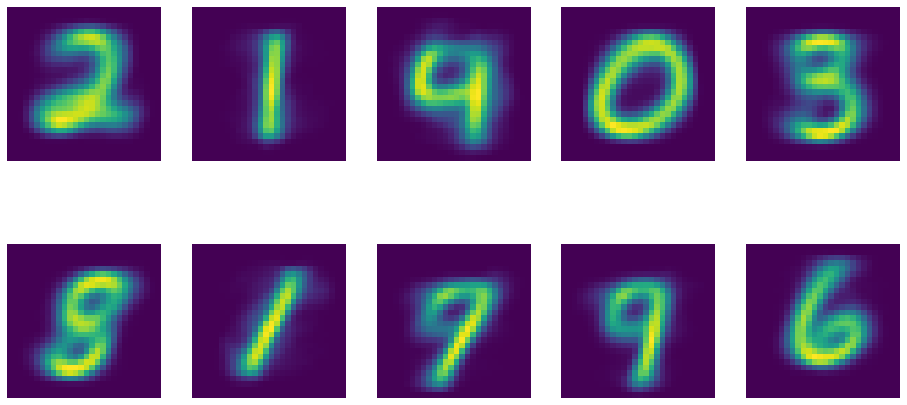

In [88]:
center=[]
for i in set(hierarchical_labels):
    x = np.mean(X_data[kmeans_labels == i], axis=0)
    center.append(list(x))
kmeans_centers = np.array(center)
f, ax = plt.subplots(2,5,figsize=(16,8))
count = 0
for i in range(2):
    for j in range(5):
        ax[i, j].imshow(kmeans_centers[count].reshape(28,28))
        ax[i, j].set_axis_off()
        count += 1
plt.show()

**_Hierarchical clustering with original data_**

In [100]:
hierarchical_clustering = AgglomerativeClustering(n_clusters=10).fit(X_data)
hierarchical_labels = hierarchical_clustering.labels_
silhouette_score_agglomerative_clustering_all_features = (silhouette_score(X_data, hierarchical_labels))
v_measure_score_agglomerative_clustering_all_features = (v_measure_score(y_data, hierarchical_labels))
print('Hierarhical clustering V score: ', v_measure_score_agglomerative_clustering_all_features)
print('Hierarhical clustering Silhouette score: ',silhouette_score_agglomerative_clustering_all_features)

Hierarhical clustering V score:  0.6861090374254432
Hierarhical clustering Silhouette score:  0.03456768561664509


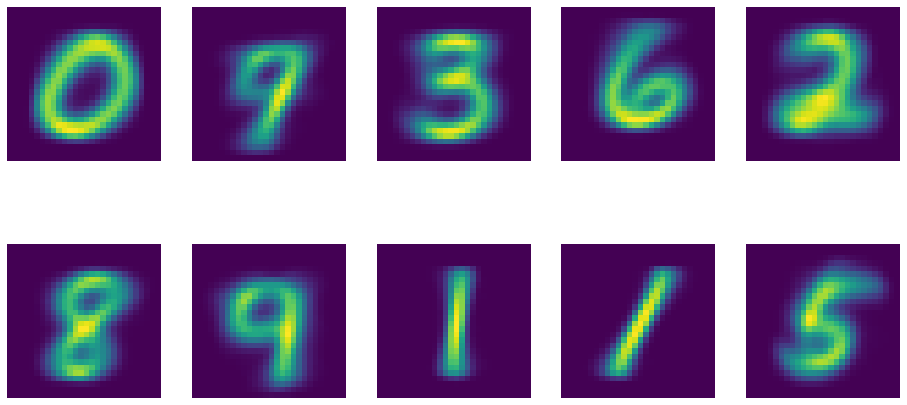

In [90]:
center=[]
for i in set(hierarchical_labels):
    x = np.mean(X_data[hierarchical_labels == i], axis=0)
    center.append(list(x))
hierarchical_clustering_centers = np.array(center)
f, ax = plt.subplots(2,5,figsize=(16,8))
count = 0
for i in range(2):
    for j in range(5):
        ax[i, j].imshow(hierarchical_clustering_centers[count].reshape(28,28))
        ax[i, j].set_axis_off()
        count += 1
plt.show()

**_Kmeans with TruncatedSVD_**

In [91]:
number_of_components = [2, 5, 10, 20]
silhouette_score_kmeans = []
v_measure_score_kmeans = []
for the_number in number_of_components:
    truncatedSVD = TruncatedSVD(n_components=the_number)
    data_with_needed_amount_of_features = truncatedSVD.fit_transform(X_data)
    
    kmeans = KMeans(n_clusters=10, random_state=42).fit(data_with_needed_amount_of_features)
    kmeans_labels = kmeans.labels_
    v_measure_score_kmeans.append(v_measure_score(y_data, kmeans_labels))
    silhouette_score_kmeans.append(silhouette_score(X_data, kmeans_labels))
print('Kmeans after TruncatedSVD V score: ', v_measure_score_kmeans)
print('Kmeans after TruncatedSVD Silhoeutte score: ', silhouette_score_kmeans)

Kmeans after TruncatedSVD V score:  [0.20039192563107558, 0.41834535955959096, 0.4727165501034033, 0.4950010128190098]
Kmeans after TruncatedSVD Silhoeutte score:  [-0.011423470963945635, 0.059581915839211484, 0.05977810054273011, 0.05932912967015285]


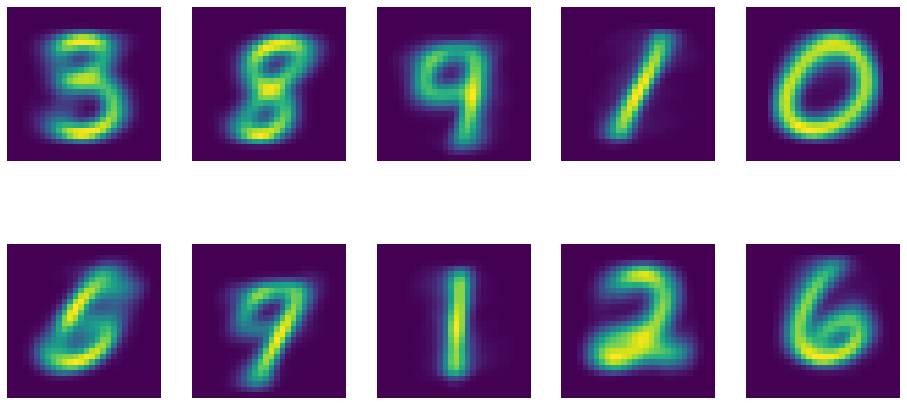

In [92]:
center=[]
for i in set(hierarchical_labels):
    x = np.mean(X_data[kmeans_labels == i], axis=0)
    center.append(list(x))
kmeans_centers = np.array(center)
f, ax = plt.subplots(2,5,figsize=(16,8))
count = 0
for i in range(2):
    for j in range(5):
        ax[i, j].imshow(kmeans_centers[count].reshape(28,28))
        ax[i, j].set_axis_off()
        count += 1
plt.show()

**_Hierarhical clustering with TruncatedSVD_**

In [94]:
number_of_components = [2, 5, 10, 20]
v_measure_score_agglomerative_clustering = []
silhouette_score_agglomerative_clustering = []
for the_number in number_of_components:
    truncatedSVD = TruncatedSVD(n_components=the_number)
    data_with_needed_amount_of_features = truncatedSVD.fit_transform(X_data)

    hierarchical_clustering = AgglomerativeClustering(n_clusters=10).fit(data_with_needed_amount_of_features)
    hierarchical_labels = hierarchical_clustering.labels_
    v_measure_score_agglomerative_clustering.append(v_measure_score(y_data, hierarchical_labels))
    silhouette_score_agglomerative_clustering.append(silhouette_score(X_data, kmeans_labels))
print('Hierarhical after TruncatedSVD V score: ', v_measure_score_agglomerative_clustering)
print('Hierarhical after TruncatedSVD Silhouette score: ', silhouette_score_agglomerative_clustering)

Hierarhical after TruncatedSVD V score:  [0.21234354912254844, 0.41345367876126227, 0.5597692312092688, 0.6297053752107975]
Hierarhical after TruncatedSVD Silhouette score:  [0.05932912967015285, 0.05932912967015285, 0.05932912967015285, 0.05932912967015285]


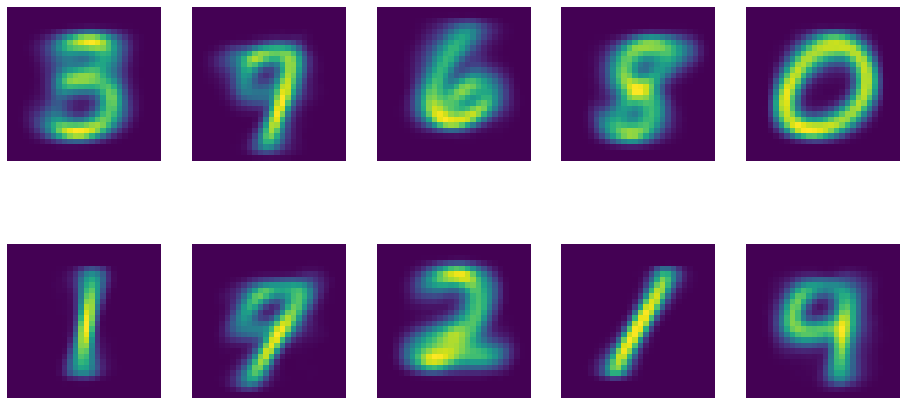

In [95]:
center=[]
for i in set(hierarchical_labels):
    x = np.mean(X_data[hierarchical_labels == i], axis=0)
    center.append(list(x))
hierarchical_clustering_centers = np.array(center)
f, ax = plt.subplots(2,5,figsize=(16,8))
count = 0
for i in range(2):
    for j in range(5):
        ax[i, j].imshow(hierarchical_clustering_centers[count].reshape(28,28))
        ax[i, j].set_axis_off()
        count += 1
plt.show()

**_Kmeans with tSNE_**

In [96]:
X_tsne_data = TSNE(n_components=2, random_state=15).fit_transform(X_data)
v_measure_score_kmeans = None
silhouette_score_kmeans = None

kmeans = KMeans(n_clusters=10, random_state=42).fit(X_tsne_data)
kmeans_labels = kmeans.labels_
v_measure_score_kmeans = v_measure_score(y_data, kmeans_labels)
print('Kmeans after tSNE V score: ', v_measure_score_kmeans)
silhouette_score_kmeans = silhouette_score(X_tsne_data, kmeans_labels)
print('Kmeans after tSNE silhouette: ', silhouette_score_kmeans)

D:\MiniConda\envs\rsschool-machine-learning-course\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\MiniConda\envs\rsschool-machine-learning-course\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Kmeans after tSNE V score:  0.7640039957835263
Kmeans after tSNE silhouette:  0.4470113


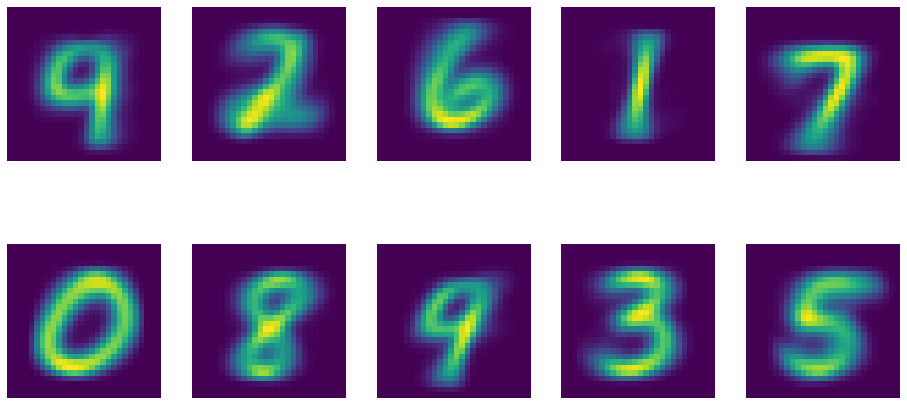

In [97]:
center=[]
for i in set(hierarchical_labels):
    x = np.mean(X_data[kmeans_labels == i], axis=0)
    center.append(list(x))
kmeans_centers = np.array(center)
f, ax = plt.subplots(2,5,figsize=(16,8))
count = 0
for i in range(2):
    for j in range(5):
        ax[i, j].imshow(kmeans_centers[count].reshape(28,28))
        ax[i, j].set_axis_off()
        count += 1
plt.show()

**_Hierarhical clustering with tSNE_**

In [98]:
X_tsne_data = TSNE(n_components=2, random_state=15).fit_transform(X_data)
v_measure_score_agglomerative_clustering = None
silhouette_score_agglomerative_clustering = None

hierarchical_clustering = AgglomerativeClustering(n_clusters=10).fit(X_tsne_data)
hierarchical_labels = hierarchical_clustering.labels_
v_measure_score_agglomerative_clustering = v_measure_score(y_data, hierarchical_labels)
silhouette_score_agglomerative_clustering = silhouette_score(X_tsne_data, hierarchical_labels)

print('Hierarhical clustering after tSNE V score: ', v_measure_score_agglomerative_clustering)
print('Hierarhical clustering after tSNE Silhouette score: ', silhouette_score_agglomerative_clustering)

D:\MiniConda\envs\rsschool-machine-learning-course\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\MiniConda\envs\rsschool-machine-learning-course\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Hierarhical clustering after tSNE V score:  0.7754024251195548
Hierarhical clustering after tSNE Silhouette score:  0.42822433


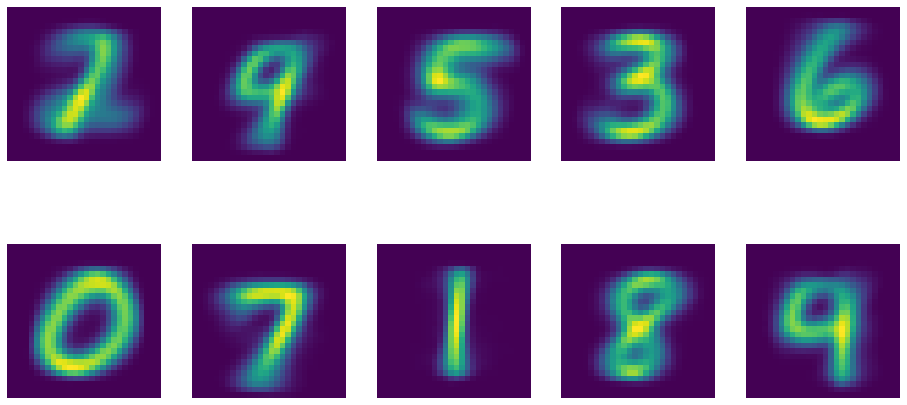

In [99]:
center=[]
for i in set(hierarchical_labels):
    x = np.mean(X_data[hierarchical_labels == i], axis=0)
    center.append(list(x))
hierarchical_clustering_centers = np.array(center)
f, ax = plt.subplots(2,5,figsize=(16,8))
count = 0
for i in range(2):
    for j in range(5):
        ax[i, j].imshow(hierarchical_clustering_centers[count].reshape(28,28))
        ax[i, j].set_axis_off()
        count += 1
plt.show()

**_Compare results of these approaches using the silhouette and the  𝑉 -score_**

To underline, in all of the approaches, cluster centers of 4 and 9 are a little bit confusing.

As for other comparision...

Original data: Kmeans V score (0.48581849830207874) is worse than Hierarhical clustering V score
0.6861090374254432, Kmeans sulhouette score 0.05740702387913833 is slightly
better than Hierahical clustering (0.03456768561664509), so we cannot
say for sure whether Kmeans or hierachical clustering is better with
original data.
    
TrunculatedSVD: with 20 features we got a V score for K means (0.4950010128190098) which is
better than a V score of Kmeans on original data. Moreover, with 20 features we got
a silhouette score (0.05932912967015285) which is better than the silhoutte
score of the original data. With other number of features, the accuracy of Kmeans decreased. With 20 features we got a V score for hierarchical clustering which is worse (0.6297053752107975) than
V score of hierarchical clustering with original data. A worse score we get with other number
of features that I used. As for the silhoutte score, it increased with 20 features and hierarchical
clustering 0.05932912967015285 and is better than the score on original data. Among Kmeans and hierarchical clustering (both with trunculatedSVD and 20 features, I think hierarchical clustering is better).
    
tSNE: Kmeans V score after tSNE is 0.7640039957835263 which is the best V score of Kmeans
that we got with different approaches. Kmeans silhouette score after tSNE is 0.4470113
which is the best silhouette score that we got with different approaches. 

Hierarchical clustering V score is 0.7754024251195548 (which is agaib the best 
that we got for hierarchical clustering) and silhouette score is
0.42822433 which is again the best for hierarchical clustering that we got. If we compare Kmeans and hierarchical clustering with TSNE V score is better for hierarchical clustering while silhouette score is better for Kmeans).


So the best Kmeans and hierarchical clustering models we get when we use tSNE.

If we compare Kmeans and hierarchical clustering, I cannot say that one is significantly better than another.